In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import pdist
from sklearn.preprocessing import *
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split

torch.manual_seed(411)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Oct 08

In [2]:
root = "../data/multibody"
times1 = [f for f in os.listdir(root) if f.startswith("X_sphere_")]
times1 = set([(root, f[9:-4]) for f in times1])

root = "../data/multibody_new/"
times2 = [f for f in os.listdir(root) if f.startswith("X_sphere_")]
times2 = set([(root, f[9:-4]) for f in times2])

times = times1 | times2

xs, ys, counts = [], [], []
for root, file in times:
    x = np.load(f"{root}/X_sphere_{file}.npy", allow_pickle=True)
    y = np.load(f"{root}/Y_sphere_{file}.npy")
    cnts = np.load(f"{root}/neighbors_{file}.npy")
    xs.append(x)
    ys.append(y)
    counts.append(cnts)

X_ragged = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)
neighbor_counts = np.concatenate(counts, axis=0)

N = len(Y)
print(N)
MAX_NEIGHBORS=10

X = np.zeros((N,11+MAX_NEIGHBORS*3), dtype=np.float64)
for i in range(N):
    nk = neighbor_counts[i]
    X[i, 0:11+nk*3] = X_ragged[i].copy()

XY = np.hstack([X, Y])          # shape: (total_rows, 16)
print(XY.shape)

#sanity check
for i in range(N):
    nk = neighbor_counts[i]
    pos = np.zeros(((nk+2), 3), dtype=np.float64)
    pos[0] = np.zeros((3,)) #target
    pos[1] = X[i, :3] #src
    pos[2:,:] = X[i, 11:11+nk*3].reshape((nk, 3))
    dd = pdist(pos)
    assert np.all(dd>2.02)

s_cols = ["x_s", "y_s", "z_s", "dist_s", "min_dist_s", 
          "f_x_s", "f_y_s", "f_z_s", "tor_x_s", "tor_y_s", "tor_z_s"]
k_cols = []
for i in range(10):
    k_cols.append(f"x_k_{i}")
    k_cols.append(f"y_k_{i}")
    k_cols.append(f"z_k_{i}")
y_cols = ["vel_x", "vel_y", "vel_z", "angvel_x", "angvel_y", "angvel_z"]
column_names = s_cols + k_cols + y_cols

df = pd.DataFrame(XY, columns=column_names)

cols_to_move = ['dist_s', 'min_dist_s'] #move them to the end
new_cols = [col for col in df.columns if col not in cols_to_move] + cols_to_move
df = df[new_cols]

df.shape, df.columns

49400
(49400, 47)


((49400, 47),
 Index(['x_s', 'y_s', 'z_s', 'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s',
        'tor_z_s', 'x_k_0', 'y_k_0', 'z_k_0', 'x_k_1', 'y_k_1', 'z_k_1',
        'x_k_2', 'y_k_2', 'z_k_2', 'x_k_3', 'y_k_3', 'z_k_3', 'x_k_4', 'y_k_4',
        'z_k_4', 'x_k_5', 'y_k_5', 'z_k_5', 'x_k_6', 'y_k_6', 'z_k_6', 'x_k_7',
        'y_k_7', 'z_k_7', 'x_k_8', 'y_k_8', 'z_k_8', 'x_k_9', 'y_k_9', 'z_k_9',
        'vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z', 'dist_s',
        'min_dist_s'],
       dtype='object'))

In [3]:
mean_dist_s = df['dist_s'].mean()
df['dist_s'] -= mean_dist_s
df['dist_s_sq'] = df['dist_s']**2
df['dist_s_sqsq'] = df['dist_s_sq']**2

origin = np.array([0.0, 0.0, 0.0])
# df['x_s'] = origin[0] - df['x_s']
# df['y_s'] = origin[1] - df['y_s']
# df['z_s'] = origin[2] - df['z_s']

In [4]:
FEATURE_NAMES = ['r_sk','r_kt','u_over_ell','rho_over_ell',
                 'inv_r_sk','inv_r_kt','cos_a','cos_b']

K: int = 10
eps: float = 1e-9

# --- s, t, geometry setup ---
s = df[['x_s', 'y_s', 'z_s']].to_numpy(dtype=np.float64)  # (N,3)
N = s.shape[0]
t = np.zeros_like(s)                                       # (N,3)  (change if you have t columns)
ell = np.linalg.norm(s - t, axis=1, keepdims=True)         # (N,1)
ell = np.clip(ell, eps, None)
zhat = (s - t) / ell                                       # (N,3)
m = 0.5 * (s + t)                                          # (N,3)

# --- neighbors as (N, K, 3) ---
ks = np.empty((N, K, 3), dtype=np.float64)
for i in range(K):
    ks[:, i, 0] = df.get(f'x_k_{i}', 0.0)
    ks[:, i, 1] = df.get(f'y_k_{i}', 0.0)
    ks[:, i, 2] = df.get(f'z_k_{i}', 0.0)

# padded neighbors are all-zeros
k_mask = np.any(ks != 0.0, axis=2)                         # (N,K) booleans

# --- distances ---
r_sk = np.linalg.norm(ks - s[:, None, :], axis=2)          # (N,K)
r_kt = np.linalg.norm(ks - t[:, None, :], axis=2)          # (N,K)
r_sk_c = np.clip(r_sk, eps, None)
r_kt_c = np.clip(r_kt, eps, None)

# --- axial & radial relative to the s–t axis ---
v = ks - m[:, None, :]                                     # (N,K,3)
u = np.sum(v * zhat[:, None, :], axis=2)                   # (N,K)
v_perp = v - u[..., None] * zhat[:, None, :]               # (N,K,3)
rho = np.linalg.norm(v_perp, axis=2)                       # (N,K)

u_over_ell   = u   / ell                                   # (N,K)
rho_over_ell = rho / ell                                   # (N,K)
inv_r_sk = 1.0 / r_sk_c
inv_r_kt = 1.0 / r_kt_c

# --- angles via law of cosines ---
# cos_a = angle at t between (k−t) and (s−t)
# cos_a = (r_kt^2 + ell^2 − r_sk^2) / (2 r_kt ell)
ell_b = np.broadcast_to(ell, r_kt.shape)                   # (N,K)
num_a = (r_kt**2 + ell_b**2 - r_sk**2)
den_a = 2.0 * r_kt_c * ell_b
cos_a = num_a / np.clip(den_a, eps, None)

# cos_b = angle at s between (k−s) and (t−s)
# cos_b = (r_sk^2 + ell^2 − r_kt^2) / (2 r_sk ell)
num_b = (r_sk**2 + ell_b**2 - r_kt**2)
den_b = 2.0 * r_sk_c * ell_b
cos_b = num_b / np.clip(den_b, eps, None)

# numeric hygiene
cos_a = np.clip(cos_a, -1.0, 1.0)
cos_b = np.clip(cos_b, -1.0, 1.0)

# --- pack features as (N,K,8) and zero-out padded entries ---
feats = np.stack(
    [r_sk, r_kt, u_over_ell, rho_over_ell, inv_r_sk, inv_r_kt, cos_a, cos_b],
    axis=2
)                                                          # (N,K,8)
feats[~k_mask] = 0.0

# --- attach to DataFrame ---
out = df.copy()

flat = feats.reshape(N, K * feats.shape[2])
wide_cols = [f'feat_{i}_{name}' for i in range(K) for name in FEATURE_NAMES]
out[wide_cols] = flat

for i in range(K):
    out[f'mask_{i}'] = k_mask[:,i].astype(np.float64)

# Drop original positions
nk_pos_cols = ['x_k_0', 'y_k_0', 'z_k_0', 'x_k_1',
        'y_k_1', 'z_k_1', 'x_k_2', 'y_k_2', 'z_k_2', 'x_k_3', 'y_k_3', 'z_k_3',
        'x_k_4', 'y_k_4', 'z_k_4', 'x_k_5', 'y_k_5', 'z_k_5', 'x_k_6', 'y_k_6',
        'z_k_6', 'x_k_7', 'y_k_7', 'z_k_7', 'x_k_8', 'y_k_8', 'z_k_8', 'x_k_9',
        'y_k_9', 'z_k_9'] + ['min_dist_s']

#out = out.drop(columns=nk_pos_cols)

out.shape, list(out.columns);

In [5]:
force_cols = [
    'f_x_s', 'f_y_s', 'f_z_s', 'tor_x_s', 'tor_y_s', 'tor_z_s'    ]
output_cols = [
    'vel_x', 'vel_y', 'vel_z',
    'angvel_x', 'angvel_y', 'angvel_z'
]
to_drop = force_cols + output_cols

feature_cols = [col for col in list(out.columns) if col not in to_drop]
print("Using features:", feature_cols)

dist_vec   = out[feature_cols].values
force_vec  = out[force_cols].values
output_vec = out[output_cols].values
feat, force, vel = dist_vec, force_vec, output_vec

Using features: ['x_s', 'y_s', 'z_s', 'x_k_0', 'y_k_0', 'z_k_0', 'x_k_1', 'y_k_1', 'z_k_1', 'x_k_2', 'y_k_2', 'z_k_2', 'x_k_3', 'y_k_3', 'z_k_3', 'x_k_4', 'y_k_4', 'z_k_4', 'x_k_5', 'y_k_5', 'z_k_5', 'x_k_6', 'y_k_6', 'z_k_6', 'x_k_7', 'y_k_7', 'z_k_7', 'x_k_8', 'y_k_8', 'z_k_8', 'x_k_9', 'y_k_9', 'z_k_9', 'dist_s', 'min_dist_s', 'dist_s_sq', 'dist_s_sqsq', 'feat_0_r_sk', 'feat_0_r_kt', 'feat_0_u_over_ell', 'feat_0_rho_over_ell', 'feat_0_inv_r_sk', 'feat_0_inv_r_kt', 'feat_0_cos_a', 'feat_0_cos_b', 'feat_1_r_sk', 'feat_1_r_kt', 'feat_1_u_over_ell', 'feat_1_rho_over_ell', 'feat_1_inv_r_sk', 'feat_1_inv_r_kt', 'feat_1_cos_a', 'feat_1_cos_b', 'feat_2_r_sk', 'feat_2_r_kt', 'feat_2_u_over_ell', 'feat_2_rho_over_ell', 'feat_2_inv_r_sk', 'feat_2_inv_r_kt', 'feat_2_cos_a', 'feat_2_cos_b', 'feat_3_r_sk', 'feat_3_r_kt', 'feat_3_u_over_ell', 'feat_3_rho_over_ell', 'feat_3_inv_r_sk', 'feat_3_inv_r_kt', 'feat_3_cos_a', 'feat_3_cos_b', 'feat_4_r_sk', 'feat_4_r_kt', 'feat_4_u_over_ell', 'feat_4_rho_o

In [6]:
dist_s_col_idx = feature_cols.index('dist_s')
dist_s_col_idx

33

In [7]:
feat, force, vel = convert_to_tensors(feat, force, vel)

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))
train_idx, val_idx = tmp.pop()

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

(torch.Size([39520, 127]), torch.Size([39520, 6]), torch.Size([9880, 127]))

## Model

In [8]:
EPS = 1e-12

def normalize(v): return v / (v.norm(dim=-1, keepdim=True) + EPS)

def outer(u):      return torch.einsum('...i,...j->...ij', u, u)
def sym_outer(u,v):return 0.5*(torch.einsum('...i,...j->...ij', u, v) +
                               torch.einsum('...i,...j->...ij', v, u))

def cross_mat(u):
    ux, uy, uz = u.unbind(dim=-1)
    O = torch.zeros(u.shape[:-1]+(3,3), device=u.device, dtype=u.dtype)
    O[...,0,1], O[...,0,2] = -uz,  uy
    O[...,1,0], O[...,1,2] =  uz, -ux
    O[...,2,0], O[...,2,1] = -uy,  ux
    return O

def create_basis(pos_flat: torch.Tensor, mask: torch.Tensor):
    """
    pos_flat: [B,33] = [x_s(3) | x_k1(3) | ... | x_k10(3)]
    mask    : [B,10] = 1.0 if neighbor k is present else 0.0

    Returns:
      e    : [B,3] unit vector along s->t (target at origin ⇒ e = -x_s/||x_s||)
      ghat : [B,3] pooled neighbor direction perpendicular to e (fallback if isotropic)
    """
    B = pos_flat.shape[0]
    assert pos_flat.shape[1] == 33
    assert mask.shape==(B,10)
    device = pos_flat.device
    dtype  = pos_flat.dtype
    eps    = 1e-12

    pos = pos_flat.view(B, 11, 3)       # 1 (source) + 10 neighbors
    x_s = pos[:, 0, :]                  # [B,3]
    x_k = pos[:, 1:, :]                 # [B,10,3]

    # e = unit vector from s to t (t at origin)
    xs2 = (x_s * x_s).sum(dim=-1, keepdim=True)                  # [B,1]
    e = -x_s / (xs2.sqrt() + eps)                                 # [B,3]

    # Neighbor rel vectors and distances
    r_sk = x_k - x_s.unsqueeze(1)       # [B,10,3]
    r_kt = x_k                          # [B,10,3]
    d_sk = (r_sk * r_sk).sum(dim=-1).sqrt() + eps                 # [B,10]
    d_kt = (r_kt * r_kt).sum(dim=-1).sqrt() + eps                 # [B,10]

    # Physics-inspired weights: w ~ 1/(r_sk * r_kt), masked
    w = mask * (1.0 / d_sk) * (1.0 / d_kt)             # [B,10]

    # Unit directions of r_sk
    f = r_sk / d_sk.unsqueeze(-1)       # [B,10,3]

    # First angular moment (vector sum) of neighbors
    g = (w.unsqueeze(-1) * f).sum(dim=1)              # [B,3]

    # Project g perpendicular to e and normalize → ghat
    g_par  = (g * e).sum(dim=-1, keepdim=True)        # [B,1]
    g_perp = g - g_par * e                            # [B,3]
    gp2 = (g_perp * g_perp).sum(dim=-1, keepdim=True)             # [B,1]
    ghat_raw = g_perp / (gp2.sqrt() + eps)                        # [B,3]

    # Robust fallback if neighbors are isotropic or empty (||g_perp|| ~ 0)
    ex = torch.zeros(B, 3, device=device, dtype=dtype); ex[:, 0] = 1.0
    ez = torch.zeros(B, 3, device=device, dtype=dtype); ez[:, 2] = 1.0

    alt1 = torch.cross(e, ex, dim=-1)                             # [B,3]
    alt1n = (alt1 * alt1).sum(dim=-1, keepdim=True).sqrt()        # [B,1]
    alt1 = alt1 / (alt1n + eps)

    alt2 = torch.cross(e, ez, dim=-1)                             # [B,3]
    alt2n = (alt2 * alt2).sum(dim=-1, keepdim=True).sqrt()        # [B,1]
    alt2 = alt2 / (alt2n + eps)

    pick_alt1 = (alt1n > 1e-6)                                    # [B,1] bool
    pick_alt1_3 = pick_alt1.expand_as(alt1)                       # [B,3]
    alt = torch.where(pick_alt1_3, alt1, alt2)                    # [B,3]

    use_alt = (gp2 < 1e-16)                                       # [B,1] bool
    use_alt_3 = use_alt.expand_as(ghat_raw)                       # [B,3]
    ghat = torch.where(use_alt_3, alt, ghat_raw)                  # [B,3]

    return e, ghat

In [9]:
class MultiBodyCorrection(nn.Module):
    def __init__(self, input_dim, two_nn_path, median_2b, mean_dist_s, dist_s_feat_loc):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 10)
        )
        self.two_nn = torch.jit.load(two_nn_path, map_location=device).eval()
        self.median_2b = median_2b
        self.mean_dist_s = mean_dist_s
        self.dist_s_feat_loc = dist_s_feat_loc

    def forward(self, X):
        return self.net(X)   

    @torch.jit.export 
    def predict_velocity(self, X, force_s): 
        e, ghat = create_basis(X[:, :33], X[:,-10:]) 
        coeff = self.net(X[:,33:]) # [B,10] 
        
        I  = torch.eye(3, device=e.device, dtype=e.dtype)[None,:,:].expand(e.shape[0],3,3)
        ee = outer(e)                                   # [B,3,3]
        gg = outer(ghat)                                # [B,3,3]
        eg = sym_outer(e, ghat)                         # [B,3,3]
        Xe = cross_mat(e)                               # [B,3,3]
        Xg = cross_mat(ghat)                            # [B,3,3]

        B0 = coeff[:,0][:,None,None]; B1 = coeff[:,1][:,None,None]
        B2 = coeff[:,2][:,None,None]; B3 = coeff[:,3][:,None,None]
        C0 = coeff[:,4][:,None,None]; C1 = coeff[:,5][:,None,None]
        D0 = coeff[:,6][:,None,None]; D1 = coeff[:,7][:,None,None]
        D2 = coeff[:,8][:,None,None]; D3 = coeff[:,9][:,None,None]

        TT = B0*I + B1*ee + B2*gg + B3*eg
        RT = C0*Xe + C1*Xg
        RR = D0*I + D1*ee + D2*gg + D3*eg

        K   = torch.zeros(e.shape[0],6,6, device=e.device, dtype=e.dtype)
        K[:,:3,:3] = TT
        K[:,3:,:3] = RT
        K[:,:3,3:] = RT
        K[:,3:,3:] = RR

        v = torch.einsum('bij,bj->bi', K, force_s)      # [B,6]
        return v

        
    #------------------------------------------------------------
    def predict_velocity_total(self, X3b, force_s, mu=1.0):
        return self.predict_two_body_from_triplet(X3b, force_s, mu) + \
               self.predict_velocity(X3b, force_s)
        

    def predict_two_body_from_triplet(self, X3b, force_s, mu=1.0):
        """
        X3b: [B, 17] triplet features in notebook order
        force_s: [B, 6] source force/torque in the lab frame (only s is nonzero)
        Returns: [B, 6] predicted two-body velocity on t due to s only
        """
        # Extract dvec_s = (x_s, y_s, z_s) which is target - source 
        # That's why the - sign
        dvec_s = -1 * X3b[:, 0:3]                         # [B,3]

        # Recover raw dist_s: centered + mean
        dist_s_centered = X3b[:, self.dist_s_feat_loc]                  # col 'dist_s'
        dist_s_raw = dist_s_centered + self.mean_dist_s

        # Build 2-body inputs
        min_dist_raw = dist_s_raw - 2.0              # [B]
        r2 = (dist_s_raw - self.median_2b)**2
        r4 = r2 * r2

        X2b = torch.cat(
            [dvec_s,
             dist_s_raw.unsqueeze(1),
             r2.unsqueeze(1),
             r4.unsqueeze(1),
             min_dist_raw.unsqueeze(1)],
            dim=1
        ).to(device)                                    # [B, 7] (sphere case)

        # Forces: only source on (s) is nonzero; target (t) = zeros
        Fs_target = torch.zeros_like(force_s, device=device)  # [B,6]
        Ft_source = force_s.to(device)                        # [B,6]

        mu_tensor = torch.tensor(float(mu), dtype=torch.float32, device=device)
        v2b = self.two_nn.predict_velocity(X2b, Fs_target, Ft_source, mu_tensor)  # [B,6]
        return v2b

    def make_residual_labels(self, X3b, force_s, y_total_3b, mu=1.0):
        """
        y_total_3b: [B,6] ground truth velocity on t from 3-body solve (s active, k passive)
        Returns residual labels: y_res = y_total_3b - v2b_pred
        """
        v2b = self.predict_two_body_from_triplet(X3b, force_s, mu)
        return y_total_3b.to(device) - v2b

## Training

In [10]:
input_dim = train_dist_tensor.shape[1] - 33
batch_size = 256
epochs = 500 

twob_path = "../data/models/two_body_combined_model.pt"
median_2b = 5.008307682776568 #copied from 2b training notebook
model = MultiBodyCorrection(input_dim, twob_path,median_2b, mean_dist_s, dist_s_col_idx).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


#criterion = nn.MSELoss()
criterion = nn.L1Loss()

n_batches = train_velocity_tensor.shape[0]//batch_size
n_batches, n_batches*batch_size, len(train_dist_tensor)

(154, 39424, 39520)

In [11]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)

with torch.no_grad():
    y_residual = model.make_residual_labels(
        train_dist_tensor, 
        train_force_tensor, 
        train_velocity_tensor, mu=1.0)

In [12]:
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, y_residual = shuffle_tensors(
        train_dist_tensor, train_force_tensor, y_residual
    )
    for it in range(n_batches):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force_s = train_force_tensor[indices]         
        Y = y_residual[indices]  

        Y_b = model.predict_velocity(X, force_s)
        loss = criterion(Y_b, Y)
        
        loss.backward()
        avg += loss.item()
        avg_data += 0 #data_loss.item()
        #avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_batches}')
        losses.append(avg/n_batches)
        data_losses.append(avg_data/n_batches)
        spsd_losses.append(avg_spsd/n_batches)

torch.save(model.state_dict(), "nbody_cross_tmp.wt")

Epoch 0, Loss: 0.10475854633690475
Epoch 5, Loss: 0.014027856429434054
Epoch 10, Loss: 0.009533239335015223
Epoch 15, Loss: 0.00879680958890973
Epoch 20, Loss: 0.007075295907554108
Epoch 25, Loss: 0.007687255144482116
Epoch 30, Loss: 0.00638845818746206
Epoch 35, Loss: 0.006950589858430934
Epoch 40, Loss: 0.0060977332699173065
Epoch 45, Loss: 0.008045497897697927
Epoch 50, Loss: 0.007360594991183319
Epoch 55, Loss: 0.006236865923002169
Epoch 60, Loss: 0.005207256007298537
Epoch 65, Loss: 0.006233915320730635
Epoch 70, Loss: 0.005336564127960569
Epoch 75, Loss: 0.005897317795300639
Epoch 80, Loss: 0.004889826768065815
Epoch 85, Loss: 0.005232137851658967
Epoch 90, Loss: 0.005546610778221836
Epoch 95, Loss: 0.005239065471951934
Epoch 100, Loss: 0.005380744362467682
Epoch 105, Loss: 0.005406263302527852
Epoch 110, Loss: 0.004644248082737935
Epoch 115, Loss: 0.004849068220257275
Epoch 120, Loss: 0.004909804901229097
Epoch 125, Loss: 0.004199533006660156
Epoch 130, Loss: 0.00457950864991100

In [13]:
Y.shape, Y_b.shape

(torch.Size([256, 6]), torch.Size([256, 6]))

## Evaluation

In [14]:
model = MultiBodyCorrection(input_dim, twob_path,median_2b, mean_dist_s, dist_s_col_idx).to(device)
model.load_state_dict(torch.load("nbody_cross_tmp.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity_total(val_dist_tensor, val_force_tensor)

In [15]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 182
val_output[jj], val_velocity_tensor[jj]

(tensor([-0.093465, -0.090250,  0.116630,  0.003389, -0.007586, -0.004824],
        device='cuda:0'),
 tensor([-0.095427, -0.095005,  0.114707,  0.007033, -0.009066, -0.004881],
        device='cuda:0'))

In [16]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 1122
val_output[jj], val_velocity_tensor[jj]

(tensor([ 0.118483, -0.037550,  0.029517,  0.007192,  0.011172, -0.012357],
        device='cuda:0'),
 tensor([ 0.125538, -0.043573,  0.026555,  0.008860,  0.009831, -0.009392],
        device='cuda:0'))

In [17]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean()**.5)

Root Mean Squared error for each of 6 output variables:
 tensor([0.006877, 0.007196, 0.006876, 0.003405, 0.003421, 0.003417],
       device='cuda:0')
Actual Magnitude:
  tensor([0.124780, 0.127367, 0.127826, 0.020547, 0.020252, 0.020266],
       device='cuda:0')
RMSE: tensor(0.005497, device='cuda:0')


In [18]:
#### Mean Relative Absolute Error
valid_mask = torch.abs(val_velocity_tensor) > 1e-6

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)

a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([2.498133, 2.392122, 2.351982, 8.037688, 8.364883, 8.089020],
       device='cuda:0')

In [19]:
a = torch.nanmean(relative_error, dim=0)
a*100

tensor([17.099667, 16.466410, 19.071276, 59.963547, 76.967003, 55.871628],
       device='cuda:0')

In [20]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([ 5.511481,  5.649660,  5.379509, 16.570524, 16.890299, 16.863031],
       device='cuda:0')

In [21]:
save_model = True
if save_model:
    scripted_model = torch.jit.script(model)
    scripted_model.save("../data/models/nbody_pinn_recovered.pt")

## Diagnosis

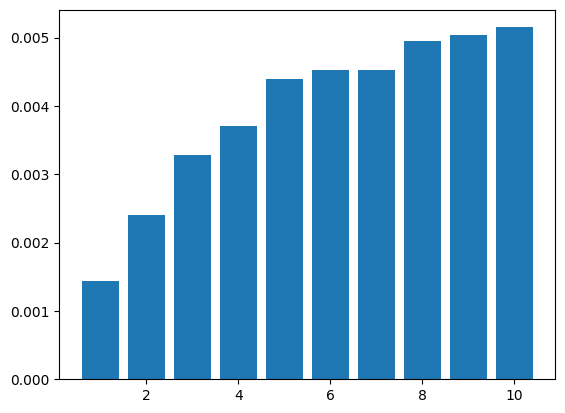

In [22]:
# No of spheres vs error

from collections import defaultdict
import matplotlib.pyplot as plt

err_nk = defaultdict(list)

for i in range(len(err)):
    nk = int(val_dist_tensor[i, -10:].sum().item())
    err_nk[nk].append(torch.sqrt(err[i].mean()).item())

for nk in err_nk:
    err_nk[nk] = sum(err_nk[nk])/len(err_nk[nk])

err_nk = sorted(err_nk.items())
plt.bar([x[0] for x in err_nk], [x[1] for x in err_nk]);

In [23]:
err_nk

[(1, 0.001443657338941756),
 (2, 0.002405620037119233),
 (3, 0.003283149612709729),
 (4, 0.003705263889995276),
 (5, 0.004391053448964945),
 (6, 0.004521639634795781),
 (7, 0.004520137011806338),
 (8, 0.004955562503982309),
 (9, 0.005032057620158376),
 (10, 0.005149737515291793)]